<a name="top"></a>
<br/>
# Machine learning thermodynamic perturbation theory (MLPT) - Algorithms
<br/>

**École Nationale Supérieure des Mines de Nancy**  
Project under the supervison of [Dario Rocca](http://crm2.univ-lorraine.fr/lab/fr/personnel/dario-rocca/) and [Fabien Pascale](https://www.researchgate.net/profile/Fabien_Pascale).  

Title: *High-accuracy materials modeling by machine learning quantum simulations*.  
Authors: [Lucas Lherbier](https://www.linkedin.com/in/lucas-lherbier/).

Last update: Feb 3rd, 2020.
<br/>

---
This notebook completes my project report. The Jupyter notebooks are divided in three parts : 
* the **[MLPT_position](MLPT_position.ipynb)** file: it creates the dataset whose features are the relative positions to an atom of reference.
* the **[MLPT_Distance](MLPT_Distance.ipynb)** file: it creates the dataset whose features are the distances of the neighbors from an atom of reference. For each configuration, all the atoms in the primitive cell are atoms of reference.
* the **[MLPT_MachineLearning](MLPT_MachineLearning.ipynb)** file: it applies machine learning algorithms to the datasets.

This notebook is the **MLPT_MachineLearning** file.

---

### Imports

In [1]:
!freeze

'freeze' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [14]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import timeit
import collections
from operator import itemgetter

from sklearn import datasets, model_selection
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import precision_score, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer,StandardScaler,normalize

import ase
from ase.io import read
from ase.visualize import view

---
<a name="def"></a>
# Data


<a name="def"></a>
## Primitive cell visualization

Thanks to the [ASE library](https://wiki.fysik.dtu.dk/ase/index.html), it is possible to visualize the primitive cell of the chabazite.

In [16]:
atom_visu =ase.io.read("first_config.xyz",format="xyz")
view(atom_visu) #open a widget
view(atom_visu, viewer='x3d')


<a name="def"></a>
## Files extraction

Our data deals with molecular biology, especially the atomic structures. Then, the data file includes one molecule, composed of 42 atoms. For each atom, we get the coordinates of the atoms.
The molecule position changes with time, then the coordinates of the atoms change. 


In [2]:
data_position = pd.read_pickle("./data_position.pkl")
data_position.head()

,A1 - P1,A1 - P2,A1 - P3,A2 - P1,A2 - P2,A2 - P3,A3 - P1,A3 - P2,A3 - P3,A4 - P1,...,A40 - P1,A40 - P2,A40 - P3,A41 - P1,A41 - P2,A41 - P3,A42 - P1,A42 - P2,A42 - P3,Energy
0,2.064315,0.329469,6.646192,0.453543,-2.909306,4.566102,0.078484,-2.056794,5.019568,0.058888,...,0.649065,-1.836236,11.482952,1.992832,0.398697,3.203989,4.855793,1.956977,6.490609,-0.006111
1,2.083317,0.513189,6.729427,0.714838,-3.324936,4.664158,0.038516,-2.496338,5.014388,0.875942,...,0.608554,-1.948710,11.346007,2.023643,0.361726,3.367719,4.901972,1.879437,6.417560,-0.046628
2,1.984442,0.548754,6.592113,1.399551,-3.581412,4.867890,2.280274,-3.286760,5.424982,-2.701399,...,0.558757,-1.861783,11.471564,1.925063,0.470993,3.316946,4.761561,1.903112,6.411927,-0.070909
3,2.055063,0.382656,6.701059,0.694871,-3.164923,4.596990,1.086989,-2.834942,5.531246,-3.254791,...,0.615444,-1.846000,11.470749,1.985753,0.429084,3.273696,4.810360,1.948595,6.534493,-0.036038
4,2.013034,0.428079,6.662569,1.162095,-3.648593,4.892707,1.750001,-3.989799,5.736131,-3.180766,...,0.698391,-1.726378,11.341388,1.899574,0.447717,3.283343,4.613570,2.040584,6.539217,-0.030054


In [3]:
data_distance = pd.read_pickle("./data_distance.pkl")
data_distance.head()

,Al 1,C 1,H 1,H 2,H 3,H 4,H 5,O 1,O 2,O 3,...,Si 1,Si 2,Si 3,Si 4,Si 5,Si 6,Si 7,Si 8,Si 9,Energy
0,0.0,4.172653,2.388621,3.504808,3.878122,0.000000,0.0,1.687689,1.712646,1.741808,...,6.072488,6.290598,7.550399,8.146431,10.333766,0.000000,0.0,0.0,0.0,-0.006111
1,0.0,4.568290,2.468720,4.022415,4.214737,0.000000,0.0,1.703726,1.713953,1.716739,...,4.459793,6.039066,6.220273,7.574809,8.109587,10.501410,0.0,0.0,0.0,-0.046628
2,0.0,4.513681,2.613852,4.020059,4.122451,6.014900,0.0,1.628690,1.706415,1.746130,...,4.435719,5.857652,6.261540,7.578781,8.146058,10.294889,0.0,0.0,0.0,-0.070909
3,0.0,4.343103,2.359981,3.557888,4.507440,6.388042,0.0,1.690680,1.707743,1.758357,...,4.573852,6.070746,6.265656,7.507522,8.151083,10.237999,0.0,0.0,0.0,-0.036038
4,0.0,4.525015,2.542304,3.917335,4.521628,5.731700,0.0,1.670785,1.685060,1.719032,...,4.528103,5.822906,6.160028,7.251170,8.275507,10.157833,0.0,0.0,0.0,-0.030054


In [2]:
inv_data_distance = pd.read_pickle("./inv_data_distance.pkl")
inv_data_distance.head()

,Al 1,C 1,H 1,H 2,H 3,H 4,H 5,O 1,O 2,O 3,...,Si 1,Si 2,Si 3,Si 4,Si 5,Si 6,Si 7,Si 8,Si 9,Energy
0,0.0,0.239656,0.418652,0.285322,0.257857,0.000000,0.0,0.592526,0.583892,0.574116,...,0.164677,0.158967,0.132443,0.122753,0.096770,0.000000,0.0,0.0,0.0,-0.006111
1,0.0,0.218900,0.405068,0.248607,0.237263,0.000000,0.0,0.586949,0.583447,0.582500,...,0.224226,0.165589,0.160765,0.132017,0.123311,0.095225,0.0,0.0,0.0,-0.046628
2,0.0,0.221549,0.382577,0.248753,0.242574,0.166254,0.0,0.613991,0.586024,0.572695,...,0.225443,0.170717,0.159705,0.131947,0.122759,0.097136,0.0,0.0,0.0,-0.070909
3,0.0,0.230250,0.423732,0.281066,0.221855,0.156542,0.0,0.591478,0.585568,0.568713,...,0.218634,0.164724,0.159600,0.133200,0.122683,0.097675,0.0,0.0,0.0,-0.036038
4,0.0,0.220994,0.393344,0.255276,0.221159,0.174468,0.0,0.598521,0.593451,0.581723,...,0.220843,0.171736,0.162337,0.137909,0.120839,0.098446,0.0,0.0,0.0,-0.030054


---
<a name="launch"></a>
# Functions

## Final dataset

After reading the data, we have to divide our dataset in two dataset : 
* the *train dataset*: it is used as examples used for learning and fit the parameters 
* the *test dataset*: it is only used as examples to assess the performance (i.e. generalization) of an algorithm


In [3]:
def final_dataset(data, prop):
    X_dataset = data.iloc[:,:-1] 
    y_dataset = data.iloc[:,-1:] 

    X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size= prop)
    return X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy().ravel(), y_test.to_numpy().ravel()


## Machine learning

We create several useful functions:
* `my_score`: return the mean squared error of an input *model* prediction from a data set *X_input*, compared to the real value *y_real*;
* `plot_non_standardized_model`: compute a input machine learning *model*. Plot the predictions, the train and test errors;
* `plot_standardized_model`: compute a input machine learning *model* after standardizing the data. Plot the predictions, the train and test errors;
* `plot_predictions`: plot the *input* predictions, train and test errors;

In [4]:
def my_score(y_real, y_pred):
    error = np.sqrt(mean_squared_error(y_real,y_pred))
    return round(error,5) 


def plot_non_standardized_model (model, X_train, X_test, y_train, y_test, text, title): 
    start = timeit.default_timer()
    
    model.fit(X_train, y_train)
    
    y_pred_train =  model.predict(X_train)
    error_train =  my_score(y_pred_train, y_train)
    
    y_pred = model.predict(X_test)
    error_test = my_score(y_pred, y_test)
    
    nb = len(X_test)
    plot_predictions(nb, y_test, y_pred, error_train, error_test, text, title)
    stop = timeit.default_timer()
    print("Processing time: %0.2f s" % (stop - start))
    return


def plot_standardized_model(model, X_train, X_test, y_train, y_test, text, title): 
    start = timeit.default_timer()
    
    X_train_n = StandardScaler(with_std=False).fit_transform(X_train)
    X_test_n = StandardScaler(with_std=False).fit(X_train).transform(X_test)
    
    model.fit(X_train_n, y_train)

    y_pred_train =  model.predict(X_train_n)
    error_train =  my_score(y_train, y_pred_train)
    
    y_pred = model.predict(X_test_n)
    error_test = my_score(y_test, y_pred)
    
    nb = len(X_test)
    plot_predictions(nb, y_test, y_pred, error_train, error_test, text, title)
    stop = timeit.default_timer()
    print("Processing time: %0.2f s" % (stop - start))
    return


def plot_predictions(nb,y_test, y_pred, error_train, error_test, text, title):
    error_test_kcal = error_train*23
    error_train_kcal = error_test*23
    
    fig, ax = plt.subplots()
    p1 = plt.scatter(range(0,nb), y_test,color='green')
    p2 = plt.scatter(range(0,nb),y_pred, color='blue')
    plt.ylabel('Adsorption Energy ')
    plt.xlabel('Molecule Index')
    plt.legend([p1, p2], ["Label", "Prediction"])
    ax.text(1.05, 0.5, text + 
            '\n \nTrain RMSE :\n' + str(error_train) + ' eV \n' + str(round(error_train*23,4)) + ' kcal/mol \n'
            '\n \nTest RMSE :\n' + str(error_test) + ' eV \n' + str(round(error_test*23,4)) + ' kcal/mol \n',
            transform=ax.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='left')
    plt.title(title, fontsize=14)
    plt.show()

---
<a name="launch"></a>
## Cross validation

Hyper-parameters are parameters that are not directly learnt within estimators. For instance, it is the parameters passed as arguments in the models, such as the type of solver for the MLP Regressor.  
In fact, it is possible to search the hyper-parameter space for the best cross validation score. Any parameter provided when constructing an estimator may be optimized in this manner.

We create 2 useful functions:
* `param_non_standardized_gridsearch` : for the best unstandardized model created with a combination of the parameters input, plot its cross-val score and its parameters.
* `param_standardized_gridsearch` : for the best standardized model created with a combination of the parameters input, plot its cross-val score and its parameters.

In [5]:
def param_non_standardized_gridsearch(param,X_train,y_train):
    start = timeit.default_timer()
    param.fit(X_train,y_train)
    
    score = np.sqrt(-param.best_score_)
    print("Meileur score pour le train dataset: %0.4f eV" % score)
    print("Meileur score pour le train dataset: %0.4f kcal/mol" % (score*23))
    print("Avec les paramètres:", param.best_params_)
    
    stop = timeit.default_timer()
    print("Processing time: %0.2f s" % (stop - start))
    return param.best_params_


def param_standardized_gridsearch(param,X_train,y_train):
    start = timeit.default_timer()
    X_train_n = StandardScaler().fit_transform(X_train)
    param.fit(X_train_n, y_train)
    
    score = np.sqrt(-param.best_score_)
    print("Meileur score pour le train dataset: %0.4f eV" % score)
    print("Meileur score pour le train dataset: %0.4f kcal/mol" % (score*23))
    print("Avec les paramètres:", param.best_params_)
    
    stop = timeit.default_timer()
    print("Processing time: %0.2f s" % (stop - start))
    return param.best_params_

---
<a name="launch"></a>

# Machine learning

## Position descriptors

### Basic simulations

#### Random Forest

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

We start with the *`Random Forest Regressor`* in order to predict our adsorption energy.
We make test the good performance of our previous functions with random examples.

In [35]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos = final_dataset(data_position, 0.5)
print("The shape of the X_train set is:", X_train_pos.shape)
print("The shape of the y_train set is:", y_train_pos.shape)

The shape of the X_train set is: (100, 126)
The shape of the y_train set is: (100,)


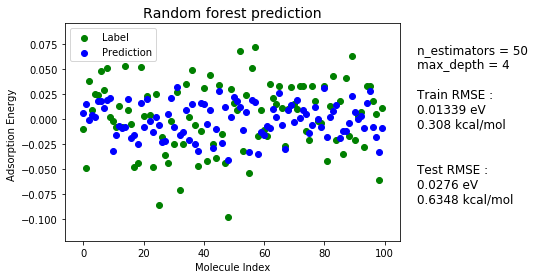

Processing time: 0.61 s


In [17]:
model = RandomForestRegressor(n_estimators=50, max_depth=4, random_state=0)
plot_non_standardized_model(model, X_train_pos, X_test_pos, y_train_pos, y_test_pos, 'n_estimators = 50 \nmax_depth = 4','Random forest prediction')

#### Kernel Ridge Regression

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

Moreover, we use make a *Kernel Ridge Regression* in order to predict our adsorption energy. For each training, we will use normalized data.

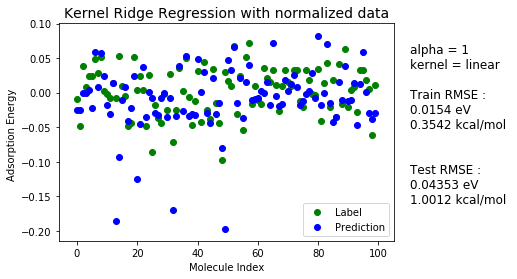

Processing time: 0.43 s


In [18]:
model = KernelRidge(alpha=1,kernel = 'linear')
plot_standardized_model(model, X_train_pos, X_test_pos, y_train_pos, y_test_pos, 'alpha = 1 \nkernel = linear','Kernel Ridge Regression with normalized data')

#### MLP Regressor

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp#sklearn.neural_network.MLPRegressor)

Then, we use make a *MLP Regressor* in order to predict our adsorption energy. For each training, we will use standardized data. We will test 3 times with different parameters : 
* 1st test : `solver='adam'`
* 2nd test : `solver='lbfgs'`

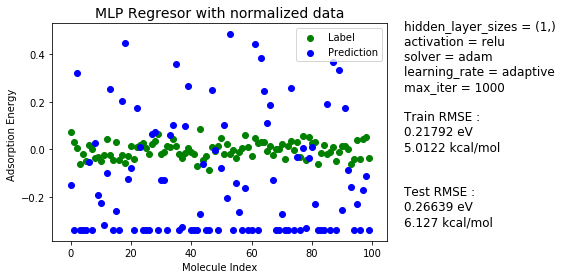

Processing time: 0.46 s


In [26]:
model = MLPRegressor(hidden_layer_sizes=(1,),activation='relu',solver='adam',learning_rate='adaptive',max_iter=1000, random_state=2)
plot_standardized_model(model, X_train_pos, X_test_pos, y_train_pos, y_test_pos, 'hidden_layer_sizes = (1,) \nactivation = relu \nsolver = adam \nlearning_rate = adaptive \nmax_iter = 1000','MLP Regresor with normalized data')

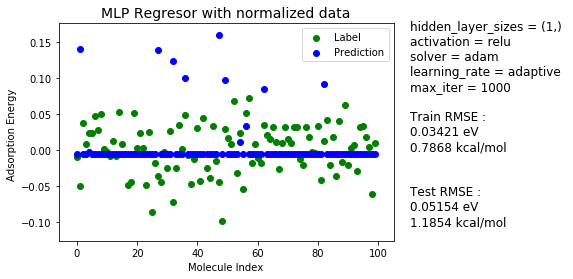

Processing time: 0.47 s


In [20]:
model = MLPRegressor(hidden_layer_sizes=(1,),activation='relu',solver='lbfgs',learning_rate='adaptive',max_iter=1000, random_state=32)
plot_standardized_model(model, X_train_pos, X_test_pos, y_train_pos, y_test_pos, 'hidden_layer_sizes = (1,) \nactivation = relu \nsolver = adam \nlearning_rate = adaptive \nmax_iter = 1000','MLP Regresor with normalized data')

### Cross validation

#### Random Forest

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)


In [25]:
gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': (50,100,200,300),'max_depth': 
                [2,4,8,16,32],'max_features': (3,6,12,24,48)}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error') #,100,200
paramgs = param_non_standardized_gridsearch(gs,X_train_pos,y_train_pos)

Meileur score pour le train dataset: 0.0274 eV
Meileur score pour le train dataset: 0.6310 kcal/mol
Avec les paramètres: {'max_depth': 8, 'max_features': 24, 'n_estimators': 100}
Processing time: 100.06 s


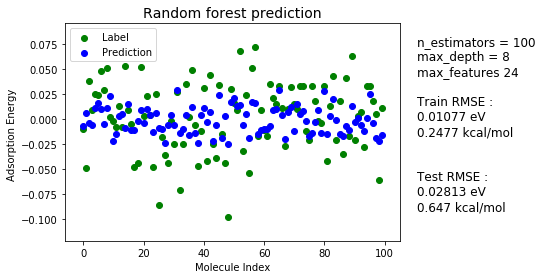

Processing time: 0.88 s


In [26]:
model = RandomForestRegressor(n_estimators=paramgs['n_estimators'], max_depth=paramgs['max_depth'], max_features = paramgs['max_features'], random_state=0)
plot_non_standardized_model(model, X_train_pos, X_test_pos, y_train_pos, y_test_pos, 'n_estimators = '+str(paramgs['n_estimators'])+'\nmax_depth = '+str(paramgs['max_depth'])+'\nmax_features '+str(paramgs['max_features']),'Random forest prediction')

#### Kernel Ridge Regression

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)


In [36]:
krr = GridSearchCV(estimator=KernelRidge(), param_grid={'alpha': [0.001,0.01,0.1,1,2,5,10,20,100],'kernel': ['rbf','laplacian','linear'],'gamma': [0.01,0.1,1,2,5,10,20,100]}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
paramkrr = param_standardized_gridsearch(krr,X_train_pos,y_train_pos)

Meileur score pour le train dataset: 0.0247 eV
Meileur score pour le train dataset: 0.5691 kcal/mol
Avec les paramètres: {'alpha': 100, 'gamma': 0.01, 'kernel': 'linear'}
Processing time: 1.79 s


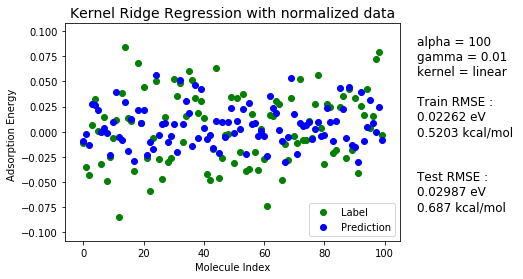

Processing time: 0.45 s


In [37]:
model = KernelRidge(alpha = paramkrr['alpha'], gamma = paramkrr['gamma'], kernel = paramkrr['kernel'])
plot_standardized_model(model, X_train_pos, X_test_pos, y_train_pos, y_test_pos, 'alpha = '+str(paramkrr['alpha'])+'\ngamma = '+str(paramkrr['gamma'])+'\nkernel = '+str(paramkrr['kernel']),'Kernel Ridge Regression with normalized data')

#### MLP Regressor

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp#sklearn.neural_network.MLPRegressor)

In [43]:
mlp = GridSearchCV(estimator=MLPRegressor(), param_grid={'hidden_layer_sizes':[1,2,5,10,20,30,50,100,200,300,500], 'activation':['relu'], 'solver':['adam','lbfgs','sgd'], 'max_iter': [200,500,1000,1500]}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
parammlp = param_standardized_gridsearch(mlp,X_train_pos,y_train_pos)

Meileur score pour le train dataset: 0.0518 eV
Meileur score pour le train dataset: 1.1913 kcal/mol
Avec les paramètres: {'activation': 'relu', 'hidden_layer_sizes': 2, 'max_iter': 500, 'solver': 'lbfgs'}
Processing time: 67.57 s


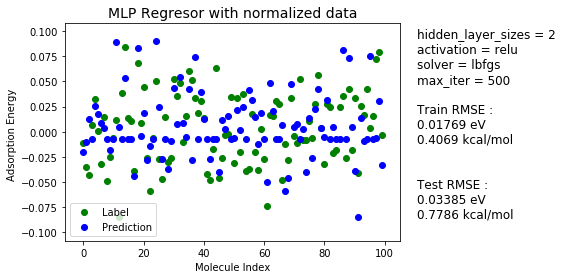

Processing time: 0.46 s


In [44]:
model = MLPRegressor(hidden_layer_sizes=(parammlp['hidden_layer_sizes'],),activation=parammlp['activation'],
                     solver=parammlp['solver'],learning_rate='adaptive',max_iter=parammlp['max_iter'], random_state=2)
plot_standardized_model(model, X_train_pos, X_test_pos, y_train_pos, y_test_pos, 'hidden_layer_sizes = '+str(parammlp['hidden_layer_sizes'])+'\nactivation = '+str(parammlp['activation'])+'\nsolver = '+str(parammlp['solver'])+'\nmax_iter = '+str(parammlp['max_iter']),'MLP Regresor with normalized data')


## Distance descriptors

### Basic simulations

#### Random Forest

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

We start with the *`Random Forest Regressor`* in order to predict our adsorption energy.
We make test the good performance of our previous functions with random examples.

In [82]:
X_train_dist, X_test_dist, y_train_dist, y_test_dist = final_dataset(data_distance, 0.5)
print("The shape of the X_train set is:", X_train_dist.shape)
print("The shape of the y_train set is:", y_train_dist.shape)

The shape of the X_train set is: (100, 1386)
The shape of the y_train set is: (100,)


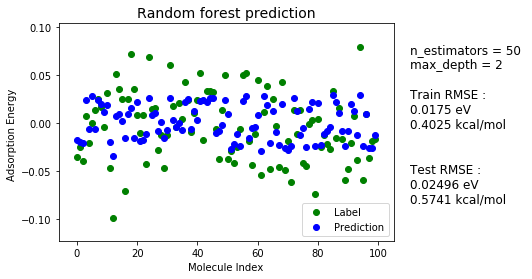

Processing time: 0.60 s


In [43]:
model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=0)
plot_non_standardized_model(model, X_train_dist, X_test_dist, y_train_dist, y_test_dist, 'n_estimators = 50 \nmax_depth = 2','Random forest prediction')

#### Kernel Ridge Regression

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)


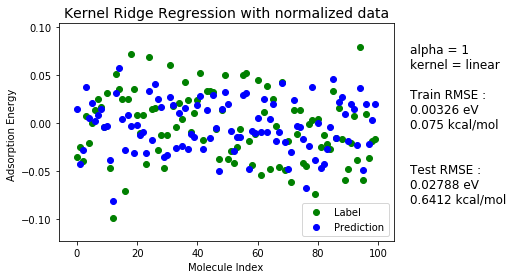

Processing time: 0.22 s


In [44]:
model = KernelRidge(alpha=1,kernel = 'linear')
plot_standardized_model(model, X_train_dist, X_test_dist, y_train_dist, y_test_dist, 'alpha = 1 \nkernel = linear','Kernel Ridge Regression with normalized data')

#### MLP Regressor

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp#sklearn.neural_network.MLPRegressor)

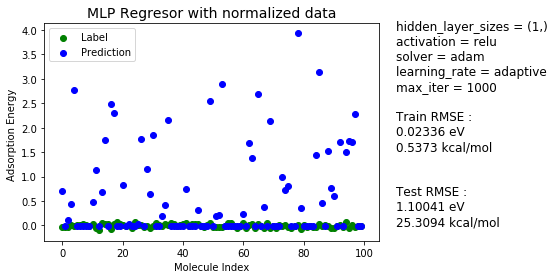

Processing time: 0.28 s


In [45]:
model = MLPRegressor(hidden_layer_sizes=(1,),activation='relu',solver='lbfgs',learning_rate='adaptive',max_iter=1000, random_state=2)
plot_standardized_model(model, X_train_dist, X_test_dist, y_train_dist, y_test_dist, 'hidden_layer_sizes = (1,) \nactivation = relu \nsolver = adam \nlearning_rate = adaptive \nmax_iter = 1000','MLP Regresor with normalized data')

### Cross validation

#### Random Forest

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)


In [72]:
gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': (50,100,200,300),'max_depth': 
                [2,4,8,16,32,64],'max_features': (3,6,12,24,48,96)}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error') #,100,200
paramgs = param_non_standardized_gridsearch(gs,X_train_dist,y_train_dist)

Meileur score pour le train dataset: 0.0246 eV
Meileur score pour le train dataset: 0.5649 kcal/mol
Avec les paramètres: {'max_depth': 16, 'max_features': 96, 'n_estimators': 200}
Processing time: 145.18 s


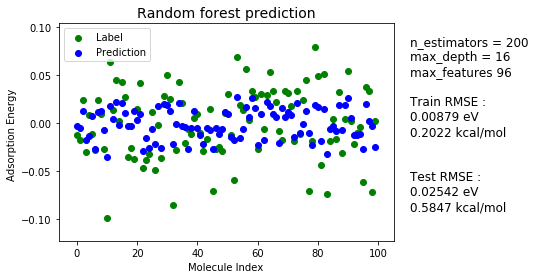

Processing time: 1.78 s


In [74]:
model = RandomForestRegressor(n_estimators=paramgs['n_estimators'], max_depth=paramgs['max_depth'], max_features = paramgs['max_features'], random_state=0)
plot_non_standardized_model(model, X_train_dist, X_test_dist, y_train_dist, y_test_dist, 'n_estimators = '+str(paramgs['n_estimators'])+'\nmax_depth = '+str(paramgs['max_depth'])+'\nmax_features '+str(paramgs['max_features']),'Random forest prediction')

#### Kernel Ridge Regression

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)


In [61]:
krr = GridSearchCV(estimator=KernelRidge(), param_grid={'alpha': [0.001,0.01,0.1,1,2,5,10,20,100],'kernel': ['rbf','laplacian','linear'],'gamma': [0.01,0.1,1,2,5,10,20,100]}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
paramkrr = param_standardized_gridsearch(krr, X_train_dist, y_train_dist)

Meileur score pour le train dataset: 0.0247 eV
Meileur score pour le train dataset: 0.5677 kcal/mol
Avec les paramètres: {'alpha': 100, 'gamma': 0.01, 'kernel': 'linear'}
Processing time: 7.95 s


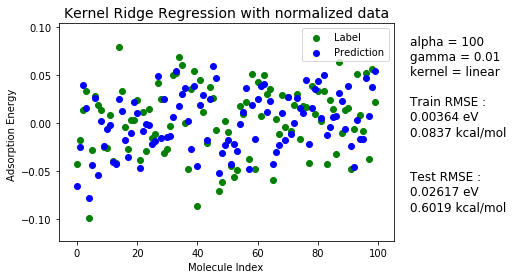

Processing time: 0.38 s


In [62]:
model = KernelRidge(alpha = paramkrr['alpha'], gamma = paramkrr['gamma'], kernel = paramkrr['kernel'])
plot_standardized_model(model, X_train_dist, X_test_dist, y_train_dist, y_test_dist, 'alpha = '+str(paramkrr['alpha'])+'\ngamma = '+str(paramkrr['gamma'])+'\nkernel = '+str(paramkrr['kernel']),'Kernel Ridge Regression with normalized data')

#### MLP Regressor

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp#sklearn.neural_network.MLPRegressor)

In [83]:
mlp = GridSearchCV(estimator=MLPRegressor(), param_grid={'hidden_layer_sizes':[(1,1),(2,1),(4,1),(20,1),(50,1),(100,1),(250,1),(5,2),(10,2),(30,2),(5,3),(10,4)], 'activation':['relu'], 'solver':['adam','lbfgs','sgd'], 'max_iter': [500,1000,1500]}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
parammlp = param_standardized_gridsearch(mlp, X_train_dist, y_train_dist)

Meileur score pour le train dataset: 0.0323 eV
Meileur score pour le train dataset: 0.7425 kcal/mol
Avec les paramètres: {'activation': 'relu', 'hidden_layer_sizes': (50, 1), 'max_iter': 500, 'solver': 'lbfgs'}
Processing time: 500.08 s


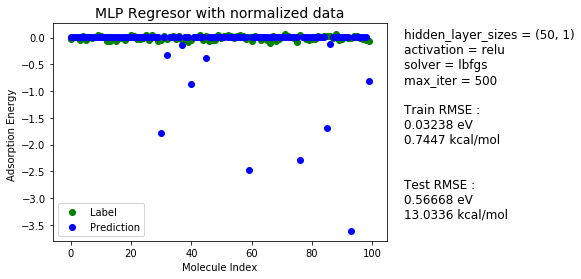

Processing time: 0.58 s


In [85]:
model = MLPRegressor(hidden_layer_sizes=parammlp['hidden_layer_sizes'],activation=parammlp['activation'],
                     solver=parammlp['solver'],learning_rate='adaptive',max_iter=parammlp['max_iter'], random_state=2)
plot_standardized_model(model, X_train_dist, X_test_dist, y_train_dist, y_test_dist, 'hidden_layer_sizes = '+str(parammlp['hidden_layer_sizes'])+'\nactivation = '+str(parammlp['activation'])+'\nsolver = '+str(parammlp['solver'])+'\nmax_iter = '+str(parammlp['max_iter']),'MLP Regresor with normalized data')

---
<a name="launch"></a>

## Inverse distance descriptor

### Basic simulations

#### Random Forest

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

We start with the *`Random Forest Regressor`* in order to predict our adsorption energy. We make test the good performance of our previous functions with random examples.

In [12]:
X_train_inv_dist, X_test_inv_dist, y_train_inv_dist, y_test_inv_dist = final_dataset(inv_data_distance, 0.5)
print("The shape of the X_train set is:", X_train_inv_dist.shape)
print("The shape of the y_train set is:", y_train_inv_dist.shape)

The shape of the X_train set is: (100, 1386)
The shape of the y_train set is: (100,)


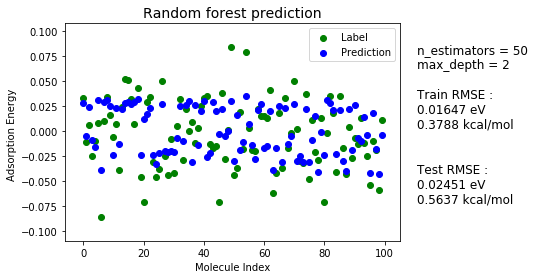

Processing time: 1.39 s


In [30]:
model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=0)
plot_non_standardized_model(model, X_train_inv_dist, X_test_inv_dist, y_train_inv_dist, y_test_inv_dist, 'n_estimators = 50 \nmax_depth = 2','Random forest prediction')

#### Kernel Ridge Regression

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)


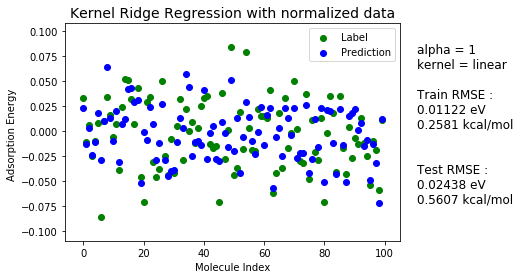

Processing time: 0.43 s


In [31]:
model = KernelRidge(alpha=1,kernel = 'linear')
plot_standardized_model(model, X_train_inv_dist, X_test_inv_dist, y_train_inv_dist, y_test_inv_dist, 'alpha = 1 \nkernel = linear','Kernel Ridge Regression with normalized data')

#### MLP Regressor

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp#sklearn.neural_network.MLPRegressor)

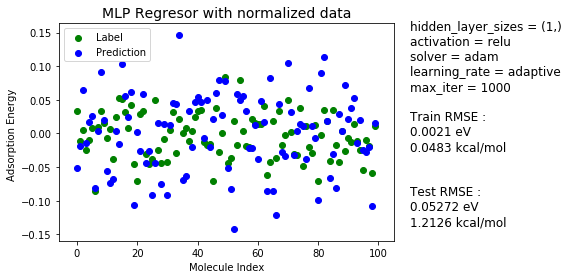

Processing time: 0.54 s


In [32]:
model = MLPRegressor(hidden_layer_sizes=(1,),activation='relu',solver='lbfgs',learning_rate='adaptive',max_iter=1000, random_state=2)
plot_standardized_model(model, X_train_inv_dist, X_test_inv_dist, y_train_inv_dist, y_test_inv_dist, 'hidden_layer_sizes = (1,) \nactivation = relu \nsolver = adam \nlearning_rate = adaptive \nmax_iter = 1000','MLP Regresor with normalized data')

### Cross validation

#### Random Forest

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)


In [97]:
gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': (50,100,200,300),'max_depth': 
                [2,4,10,30,60],'max_features': (3,6,15,30,90)}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error') #,100,200
paramgs = param_non_standardized_gridsearch(gs,X_train_inv_dist,y_train_inv_dist)

Meileur score pour le train dataset: 0.0239 eV
Meileur score pour le train dataset: 0.5491 kcal/mol
Avec les paramètres: {'max_depth': 30, 'max_features': 90, 'n_estimators': 100}
Processing time: 103.60 s


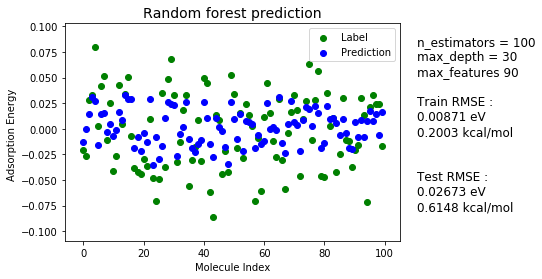

Processing time: 0.92 s


In [99]:
model = RandomForestRegressor(n_estimators=paramgs['n_estimators'], max_depth=paramgs['max_depth'], max_features = paramgs['max_features'], random_state=0)
plot_non_standardized_model(model, X_train_inv_dist, X_test_inv_dist, y_train_inv_dist, y_test_inv_dist, 'n_estimators = '+str(paramgs['n_estimators'])+'\nmax_depth = '+str(paramgs['max_depth'])+'\nmax_features '+str(paramgs['max_features']),'Random forest prediction')

#### Kernel Ridge Regression

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)


In [13]:
krr = GridSearchCV(estimator=KernelRidge(), param_grid={'alpha': [0.001,0.01,0.1,1,2,5,10,20,100],'kernel': ['rbf','laplacian','linear'],'gamma': [0.01,0.1,1,2,5,10,20,100]}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
paramkrr = param_standardized_gridsearch(krr, X_train_inv_dist, y_train_inv_dist)

Meileur score pour le train dataset: 0.0208 eV
Meileur score pour le train dataset: 0.4775 kcal/mol
Avec les paramètres: {'alpha': 100, 'gamma': 0.01, 'kernel': 'linear'}
Processing time: 4.58 s


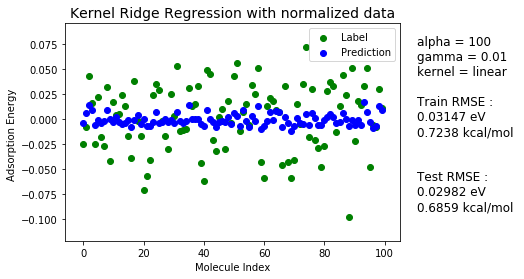

Processing time: 0.20 s


In [14]:
model = KernelRidge(alpha = paramkrr['alpha'], gamma = paramkrr['gamma'], kernel = paramkrr['kernel'])
plot_standardized_model(model, X_train_inv_dist, X_test_inv_dist, y_train_inv_dist, y_test_inv_dist, 'alpha = '+str(paramkrr['alpha'])+'\ngamma = '+str(paramkrr['gamma'])+'\nkernel = '+str(paramkrr['kernel']),'Kernel Ridge Regression with normalized data')

#### MLP Regressor

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp#sklearn.neural_network.MLPRegressor)

In [126]:
mlp = GridSearchCV(estimator=MLPRegressor(), param_grid={'hidden_layer_sizes':[(1,1),(5,1),(20,1),(50,1),(100,1),(250,1),(5,2),(10,2),(30,2),(5,3),(10,4)], 
                    'activation':['relu'], 'solver':['adam','lbfgs'], 'max_iter': [500,1000,1500]}, cv=5, n_jobs=-1, 
                     scoring='neg_mean_squared_error')
parammlp = param_standardized_gridsearch(mlp, X_train_inv_dist, y_train_inv_dist)

Meileur score pour le train dataset: 0.0354 eV
Meileur score pour le train dataset: 0.8150 kcal/mol
Avec les paramètres: {'activation': 'relu', 'hidden_layer_sizes': (250, 1), 'max_iter': 500, 'solver': 'lbfgs'}
Processing time: 428.10 s


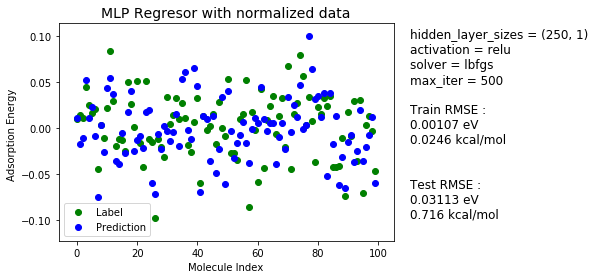

Processing time: 4.48 s


In [129]:
model = MLPRegressor(hidden_layer_sizes=parammlp['hidden_layer_sizes'],activation=parammlp['activation'],
                     solver=parammlp['solver'],learning_rate='adaptive',max_iter=parammlp['max_iter'], random_state=2)
plot_standardized_model(model, X_train_inv_dist, X_test_inv_dist, y_train_inv_dist, y_test_inv_dist, 'hidden_layer_sizes = '+str(parammlp['hidden_layer_sizes'])+'\nactivation = '+str(parammlp['activation'])+'\nsolver = '+str(parammlp['solver'])+'\nmax_iter = '+str(parammlp['max_iter']),'MLP Regresor with normalized data')

---
Back to [top](#top).